In [1]:
import pandas as pd
import json

# Load the JSON file and convert it to a DataFrame using Pandas
with open('dataset.json', 'r') as file:
    loaded_data = json.load(file)

df = pd.DataFrame.from_dict(loaded_data, orient='index')

print(df.head())


                                            question  \
1  Explain the difference between stack and queue...   
2  What is the difference between procedural prog...   
3  Describe the SOLID principles in object-orient...   
4   Explain the concept of inheritance and its im...   
5  What is the significance of version control, a...   

                                             answer1  \
1  A stack follows the Last In, First Out (LIFO) ...   
2  Procedural programming structures code as a se...   
3  SOLID is an acronym representing five principl...   
4  Inheritance in object-oriented programming all...   
5  Version control is crucial for tracking change...   

                                             answer2  \
1  A stack works on the Last In, First Out (LIFO)...   
2  Procedural programming relies on functions and...   
3  SOLID comprises five key principles in object-...   
4  Inheritance, a key concept in OOP, allows new ...   
5  Version control is essential for tracking c

## Data Preprocessing

In [2]:
df = df.drop(["question"], axis=1)

#Rename the columns
df = df.rename(columns={
    'answer1': 'statement1',
    'answer2': 'statement2',
    'answer3': 'statement3'
})

df.head()

,statement1,statement2,statement3
1,"A stack follows the Last In, First Out (LIFO) ...","A stack works on the Last In, First Out (LIFO)...","A stack operates based on Last In, First Out (..."
2,Procedural programming structures code as a se...,Procedural programming relies on functions and...,Procedural programming uses functions for task...
3,SOLID is an acronym representing five principl...,SOLID comprises five key principles in object-...,SOLID principles in OOP encompass Single Respo...
4,Inheritance in object-oriented programming all...,"Inheritance, a key concept in OOP, allows new ...",Inheritance in OOP lets new classes inherit at...
5,Version control is crucial for tracking change...,Version control is essential for tracking code...,Version control is important for tracking code...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 1 to 46
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   statement1  46 non-null     object
 1   statement2  46 non-null     object
 2   statement3  46 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


In [4]:
df.isnull().sum()

statement1    0
statement2    0
statement3    0
dtype: int64

In [5]:
df.describe()

,statement1,statement2,statement3
count,46,46,46
unique,46,46,46
top,"A stack follows the Last In, First Out (LIFO) ...","A stack works on the Last In, First Out (LIFO)...","A stack operates based on Last In, First Out (..."
freq,1,1,1


In [6]:
# Download NLTK resources if not already downloaded
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [7]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Text cleaning function
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
    return text

# Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the columns
df['statement1'] = df['statement1'].apply(preprocess_text)
df['statement2'] = df['statement2'].apply(preprocess_text)
df['statement3'] = df['statement3'].apply(preprocess_text)
df.head()

,statement1,statement2,statement3
1,stack follows last first lifo principle allowi...,stack work last first lifo principle data adde...,stack operates based last first lifo used mana...
2,procedural programming structure code sequence...,procedural programming relies function procedu...,procedural programming us function task execut...
3,solid acronym representing five principle obje...,solid comprises five key principle objectorien...,solid principle oop encompass single responsib...
4,inheritance objectoriented programming allows ...,inheritance key concept oop allows new class c...,inheritance oop let new class inherit attribut...
5,version control crucial tracking change code e...,version control essential tracking code change...,version control important tracking code change...


In [8]:
#Tf-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Function to calculate the cosine similarity between two sentences
def calculate_cosine_similarity(sentence1, sentence2):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([sentence1, sentence2])
    return cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

cosine_sim_1_2 = []
for i in range(len(df)):
    sim = calculate_cosine_similarity(df['statement1'][i], df['statement2'][i])
    cosine_sim_1_2.append(sim.item())

cosine_sim_1_3 = []
for i in range(len(df)):
    sim = calculate_cosine_similarity(df['statement1'][i], df['statement3'][i])
    cosine_sim_1_3.append(sim.item())

tf_idf_acc1 = sum(cosine_sim_1_2) / len(cosine_sim_1_2)

tf_idf_acc2 = sum(cosine_sim_1_3) / len(cosine_sim_1_3)

print("Mean cosine similarity between statement1 and statement2:", tf_idf_acc1)
print("Mean cosine similarity between statement1 and statement3:", tf_idf_acc2)


Mean cosine similarity between statement1 and statement2: 0.5687577120806907
Mean cosine similarity between statement1 and statement3: 0.49965568233249574


In [9]:
#Bert

from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def calculate_bert_cosine_similarity(statement1, statement2):
    # Tokenize the sentences
    inputs = tokenizer([statement1, statement2], return_tensors='pt', padding=True, truncation=True)
    
    # Obtain BERT embeddings
    with torch.no_grad():
        output = model(**inputs)

    embeddings = output.last_hidden_state

    # Calculate the cosine similarity between statement1 and statement2
    similarity = cosine_similarity(embeddings[0], embeddings[1])
    return similarity 

cosine_sim_1_2 = []
for i in range(len(df)):
    sim = calculate_bert_cosine_similarity(df['statement1'][i], df['statement2'][i])
    mean_sim = sim.mean()  
    cosine_sim_1_2.append(mean_sim)

cosine_sim_1_3 = []
for i in range(len(df)):
    sim = calculate_bert_cosine_similarity(df['statement1'][i], df['statement3'][i])
    mean_sim = sim.mean() 
    cosine_sim_1_3.append(mean_sim)

bert_acc1 = sum(cosine_sim_1_2) / len(cosine_sim_1_2)

bert_acc2 = sum(cosine_sim_1_3) / len(cosine_sim_1_3)

print("Mean cosine similarity between statement1 and statement2:", bert_acc1)
print("Mean cosine similarity between statement1 and statement3:", bert_acc2)


c:\Users\Sriharsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mean cosine similarity between statement1 and statement2: 0.4042816045491592
Mean cosine similarity between statement1 and statement3: 0.4189079047545143


In [10]:
# word2vec

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import nltk

# Tokenize the statements in the DataFrame
tokenized_statements = [word_tokenize(statement) for statement in df.values.flatten()]

# Train the Word2Vec model
word2vec_model = Word2Vec(tokenized_statements, vector_size=100, window=5, min_count=1, sg=0)

vectors = [np.mean([word2vec_model.wv[word] for word in statement if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for statement in tokenized_statements]

word2vec_acc1 = np.dot(vectors[0], vectors[1]) / (np.linalg.norm(vectors[0]) * np.linalg.norm(vectors[1]))
word2vec_acc2 = np.dot(vectors[0], vectors[2]) / (np.linalg.norm(vectors[0]) * np.linalg.norm(vectors[2]))

print(f"Similarity between statement 1 and statement 2: {word2vec_acc1}")
print(f"Similarity between  statement 1 and statement 3: {word2vec_acc2}")


Similarity between statement 1 and statement 2: 0.9317429065704346
Similarity between  statement 1 and statement 3: 0.8996913433074951


In [11]:
from nltk.tokenize import word_tokenize
import pandas as pd


# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0  

# Calculate Jaccard similarity between statements
tokenized_statement1 = set(word_tokenize(df['statement1'][0].lower()))
tokenized_statement2 = set(word_tokenize(df['statement2'][0].lower()))
tokenized_statement3 = set(word_tokenize(df['statement3'][0].lower()))


jaccard_acc1 = jaccard_similarity(tokenized_statement1, tokenized_statement2)
jaccard_acc2 = jaccard_similarity(tokenized_statement1, tokenized_statement3)

print(f"Jaccard Similarity between statement 1 and statement 2: {jaccard_acc1}")

print(f"Jaccard Similarity between statement 1 and statement 3: {jaccard_acc2}")


Jaccard Similarity between statement 1 and statement 2: 0.46153846153846156
Jaccard Similarity between statement 1 and statement 3: 0.37254901960784315


In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2') 

# Encode the sentences into embeddings
sentence_embeddings = model.encode(df.values.flatten().tolist(), convert_to_tensor=True)

minLM_transformer_acc1 = int(util.pytorch_cos_sim(sentence_embeddings[0:1], sentence_embeddings[1:2])[0][0] * 100) / 100
minLM_transformer_acc2 = int(util.pytorch_cos_sim(sentence_embeddings[0:1], sentence_embeddings[2:3])[0][0] * 100) / 100

print(f"Similarity between statement 1 and statement 2: {minLM_transformer_acc1}")
print(f"Similarity between statement 1 and statement 3: {minLM_transformer_acc2}")


Similarity between statement 1 and statement 2: 0.86
Similarity between statement 1 and statement 3: 0.83


In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('stsb-roberta-base')

# Encode the sentences into embeddings
sentence_embeddings = model.encode(df.values.flatten().tolist(), convert_to_tensor=True)

sbert_acc1 = int(util.pytorch_cos_sim(sentence_embeddings[0:1], sentence_embeddings[1:2])[0][0] * 100) / 100
sbert_acc2 = int(util.pytorch_cos_sim(sentence_embeddings[0:1], sentence_embeddings[2:3])[0][0] * 100) / 100

print(f"Similarity between statement 1 and statement 2: {sbert_acc1}")
print(f"Similarity between statement 1 and statement 3: {sbert_acc2}")  

Similarity between statement 1 and statement 2: 0.83
Similarity between statement 1 and statement 3: 0.78


[56.87577120806907, 40.42816045491592, 93.17429065704346, 46.15384615384615, 83.0]


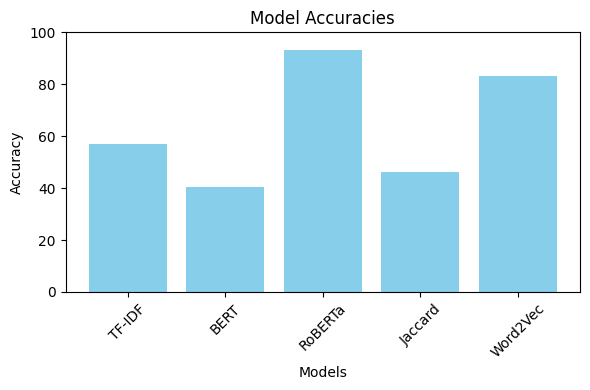

In [14]:
import matplotlib.pyplot as plt

# Accuracies for each model
accuracies = [tf_idf_acc1 * 100, bert_acc1 * 100, word2vec_acc1 * 100, jaccard_acc1 * 100, sbert_acc1 * 100]
print(accuracies)

# Models' names
models = ['TF-IDF', 'BERT', 'RoBERTa', 'Jaccard','Word2Vec']

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 100) 
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()


In [16]:
# import matplotlib.pyplot as plt

# # Accuracies for each model
# accuracies = [tf_idf_acc2 * 100, bert_acc2 * 100, word2vec_acc2 * 100, jaccard_acc2 * 100, minLM_transformer_acc2 * 100, sbert_acc2 * 100]
# print(accuracies)

# # Models' names
# models = ['TF-IDF', 'BERT', 'Word2Vec', 'Jaccard', 'MinLM Transformer', 'SBERT']

# plt.figure(figsize=(6, 4))
# plt.bar(models, accuracies, color='skyblue')
# plt.title('Model Accuracies')
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.ylim(0, 100) 
# plt.xticks(rotation=45)  
# plt.tight_layout()

# plt.show()

# https://www.kaggle.com/datasets/priyaagaikwad/technical-interview-question-and-answers
